# Markowitz Portfolio Optimization with Python

By Daniel Kerim Acatay

In [133]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# basic functionalities
import re
import os
import sys
import datetime
import itertools
import math 


# data transforamtion and manipulation
#import xarray as xr
import pandas as pd
import pandas_datareader.data as web
import numpy as np
# prevent crazy long pandas prints
pd.options.display.max_columns = 50
pd.options.display.max_rows = 6
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)


# remove warnings
import warnings
warnings.filterwarnings('ignore')


# plotting and plot styling
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid", {'axes.grid' : False})
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 20
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"

# Introduction

Modern Portfolio Theory greatly influenced how investors and portfolio managers perceive risk, return and diversification effects. Although the development of the theory dates back to 1952 it is still regarded as benchmarking


In this Notebook we will build the necessary tools for the evalation of the risk and return profiles of a real asset portfolios. In particular, this notebook features a hands-on implementation of Quadratic Programming with Python using the <code>cvxopt</code> module to find the optimal weights for a financial asset portfolio.

We will calculate and visualize the set of available market portfolios as well as calculating the optimal portfolio constellation for a desired level of expected return. This will be done for an artificial as well as a real economic data set of daily stock returns.


# Part 1: Obtaining Time Series Data

## Artificial Data

For the artificial data set we construct four time series, each with 1000 observations randomly sampled from a standard normal distribution. The artificial data will mimick the behavior of actual financial asset returns.

In [209]:
np.random.seed(1)

# length of artificial time series
n_obs = 1000

# number of different assets
n_assets = 4

# sample Nx4 data series matrix
artificial_returns = np.random.randn(n_obs, n_assets) + 0.05
artificial_returns

array([[ 1.67435, -0.56176, -0.47817, -1.02297],
       [ 0.91541, -2.25154,  1.79481, -0.71121],
       [ 0.36904, -0.19937,  1.51211, -2.01014],
       ..., 
       [ 0.12342,  0.46603, -1.8292 ,  0.62546],
       [ 0.15206,  1.2343 , -0.74484, -0.0759 ],
       [-0.91035, -0.79391,  0.67834,  0.58721]])

To get a first impression of the data we use standard techniques: simple lineplots of the data as well as the cumulative sum of each series. The cumulative sum provides a comparative description of the observed time series.

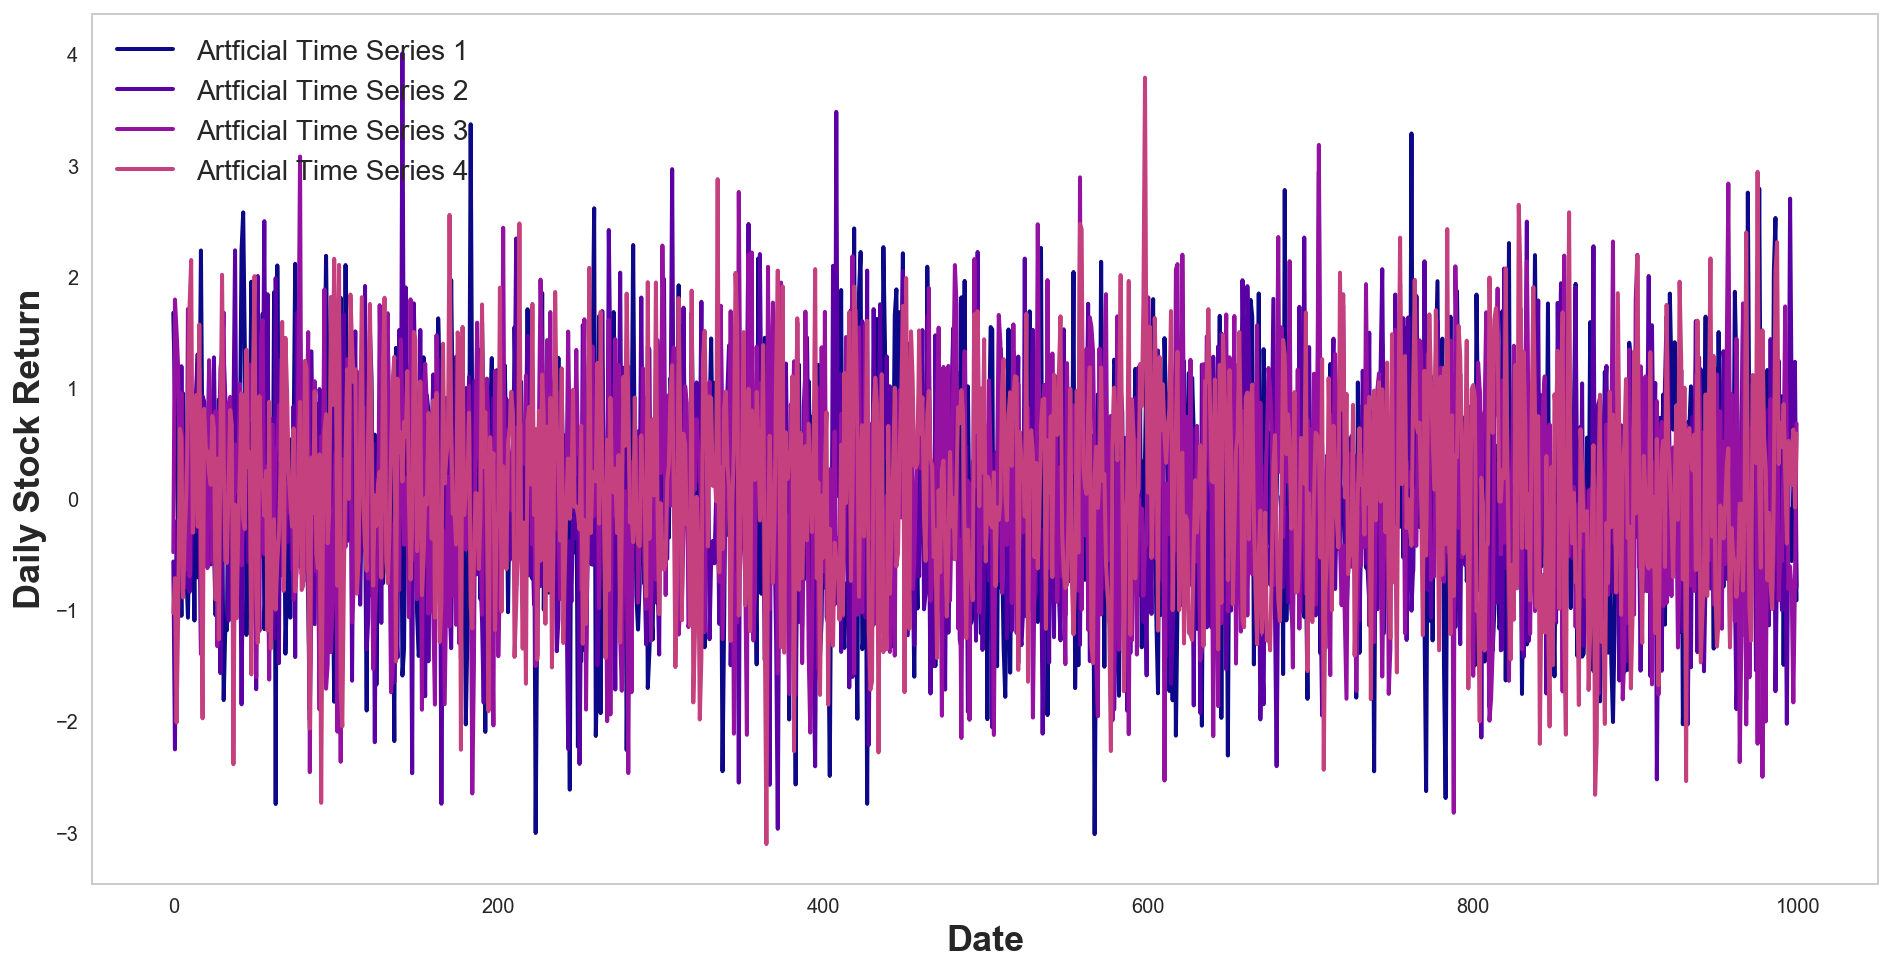

In [210]:
# get colormap
colors = plt.cm.plasma(np.linspace(0,3,20))

# plot data
for i in range(artificial_returns.shape[1]):
    plt.plot(artificial_returns.T[i], color=colors[i], label='Artficial Time Series {}'.format(i + 1));
plt.legend(loc='best');
plt.xlabel('Date');
plt.ylabel('Daily Stock Return');
plt.show()

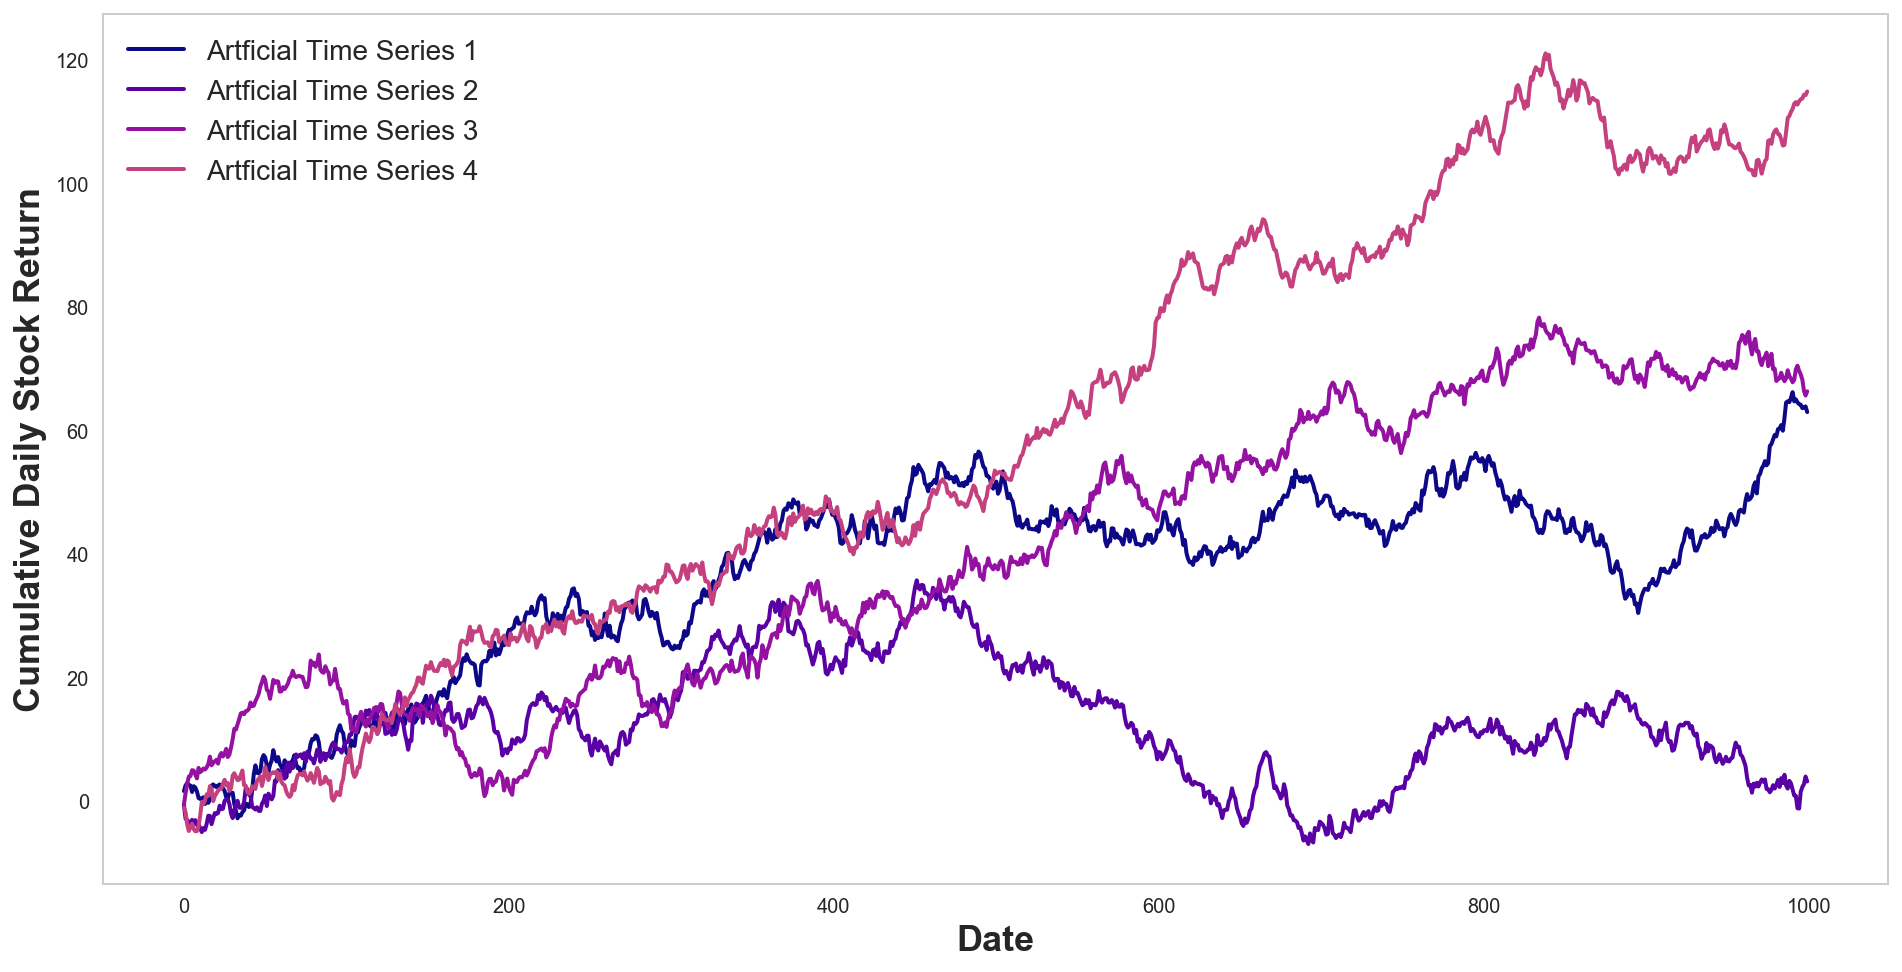

In [211]:
# get colormap
colors = plt.cm.plasma(np.linspace(0,3,20))

# plot cumulative sums
for i in range(artificial_returns.shape[1]):
    plt.plot(artificial_returns.T[i].cumsum(), color=colors[i], label='Artficial Time Series {}'.format(i + 1));
plt.legend(loc='best');
plt.xlabel('Date');
plt.ylabel('Cumulative Daily Stock Return');
plt.show()

## Download Economic Time Series Data

To obtain an economic time series data set we use the <code>pandas_datareader</code> module to access the API of financial data providers like Yahhoo! Finance, Google Finance, or the Fred. We are interested in the adjusted close prices of S&P 100 companies. Adjusted close prices are the standard close prices quotes adjusted by corporate action that have an effect on the stocks closing price, e.g. stock splits or dividend payments.

Since the computation time needed to calculate risk and return of a portfolio containing shares of all S&P 100 copanies will be way too high, we trim the analysis on real data to a selected set of companies: Microsoft, Google, Amazon, Apple, Walmart, Procter & Gamble and General Motors.

In [206]:
# define data to be downloaded
tickers = list(pd.read_csv('./data/SP100_LIST.csv', sep=';')['Symbol'])
provider = 'yahoo'
start = '2010-01-01'
end = '2017-11-14'

In [124]:
# download data
data = web.DataReader(tickers, provider, start)['Adj Close']
data.to_csv('data/data_sp100.csv', sep=';')

In [8]:
# read data from file
data = pd.read_csv('./data/data_sp100.csv', sep=';', index_col=0, header=0, parse_dates=True)

In [9]:
companies = ['GOOGL', 'MSFT', 'AMZN', 'AAPL', 'WMT', 'PG', 'GM']

In [134]:
# calculate log returns
returns = data[companies] / data[companies].shift(1) - 1
returns = returns.fillna(method='ffill').dropna()

In [135]:
returns

,GOOGL,MSFT,AMZN,AAPL,WMT,PG,GM
Date,,,,,,,
2010-11-19,-0.00961,-0.00580,0.00396,-0.00551,0.00760,0.00047,0.00205
2010-11-22,0.00066,0.00156,0.03379,0.02162,-0.00018,-0.00765,-0.00525
2010-11-23,-0.01389,-0.02371,-0.01285,-0.01478,-0.01306,-0.01495,-0.02435
...,...,...,...,...,...,...,...
2017-11-10,-0.00341,-0.00262,-0.00335,-0.00331,0.00687,0.00433,0.01306
2017-11-13,-0.00283,0.00072,0.00339,-0.00401,0.00077,0.00953,0.02133
2017-11-14,-0.00298,-0.00262,0.00571,-0.00526,-0.00198,0.00017,-0.01595


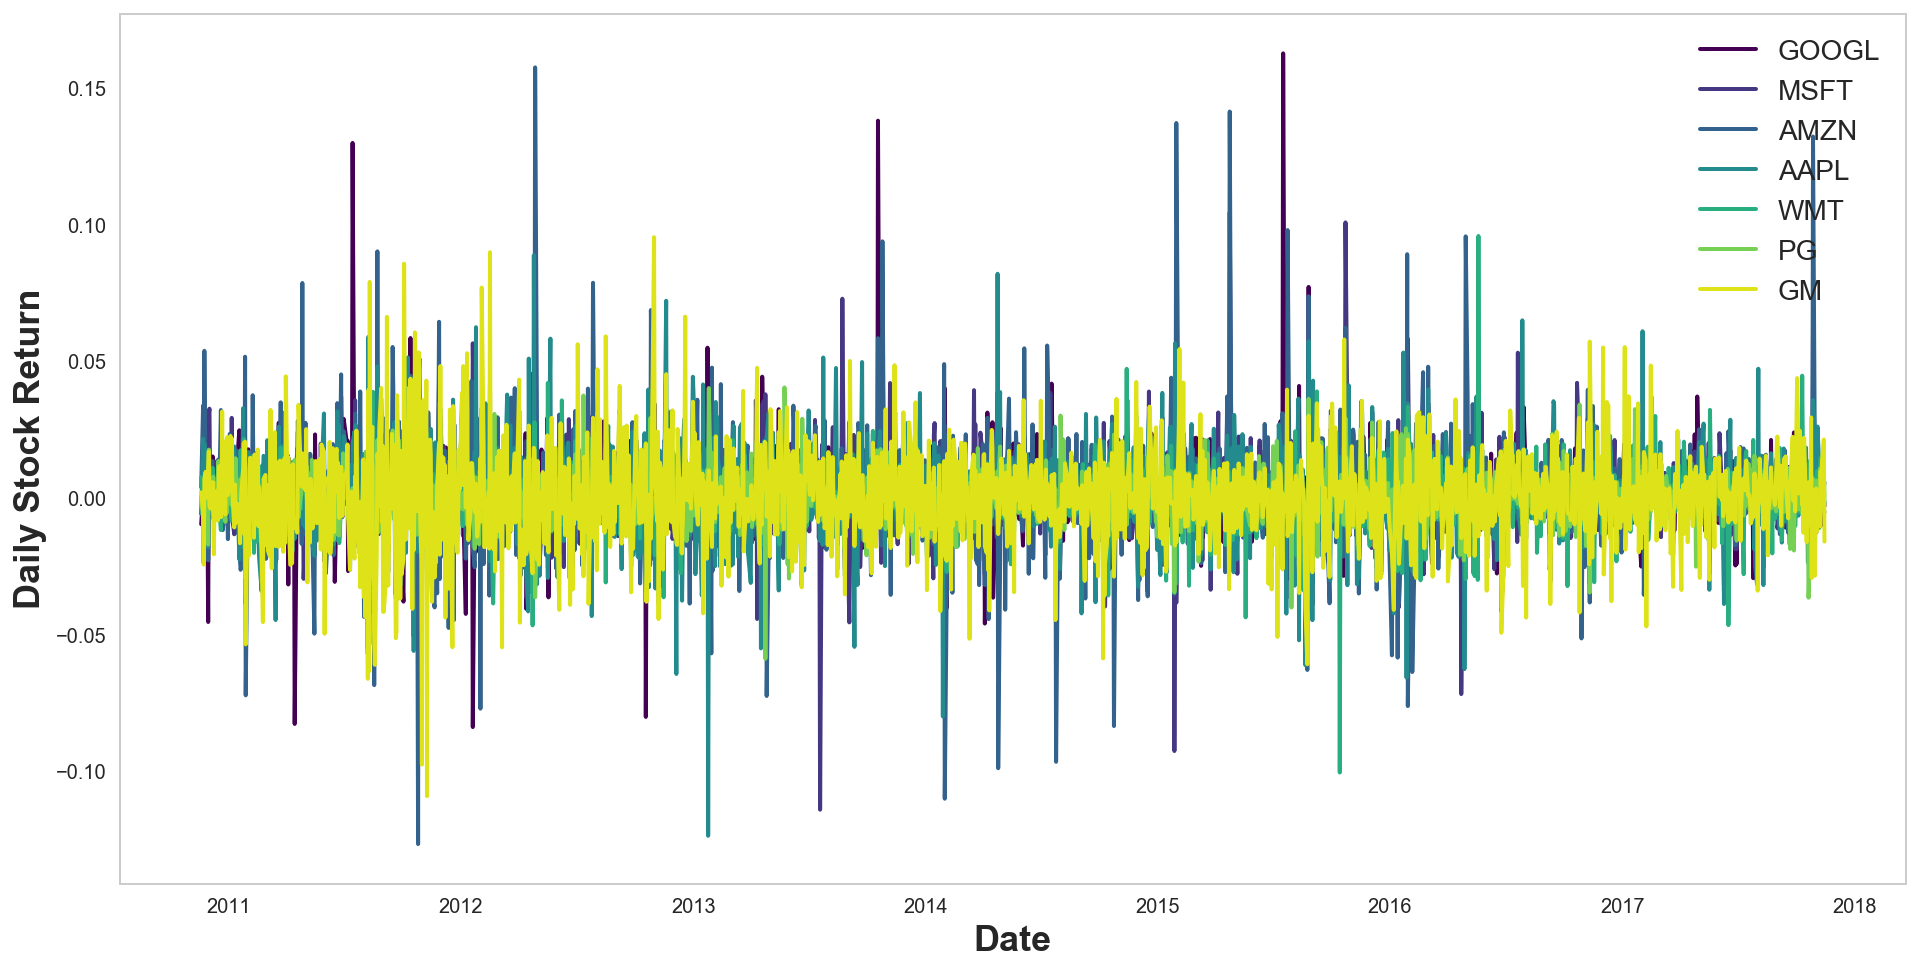

In [136]:
# get colormap
colors = plt.cm.viridis(np.linspace(0,3,20))

# plot data
for i in range(returns.shape[1]):
    plt.plot(returns.iloc[:, i], color=colors[i]);
plt.legend(loc='best');
plt.xlabel('Date');
plt.ylabel('Daily Stock Return');
plt.show()

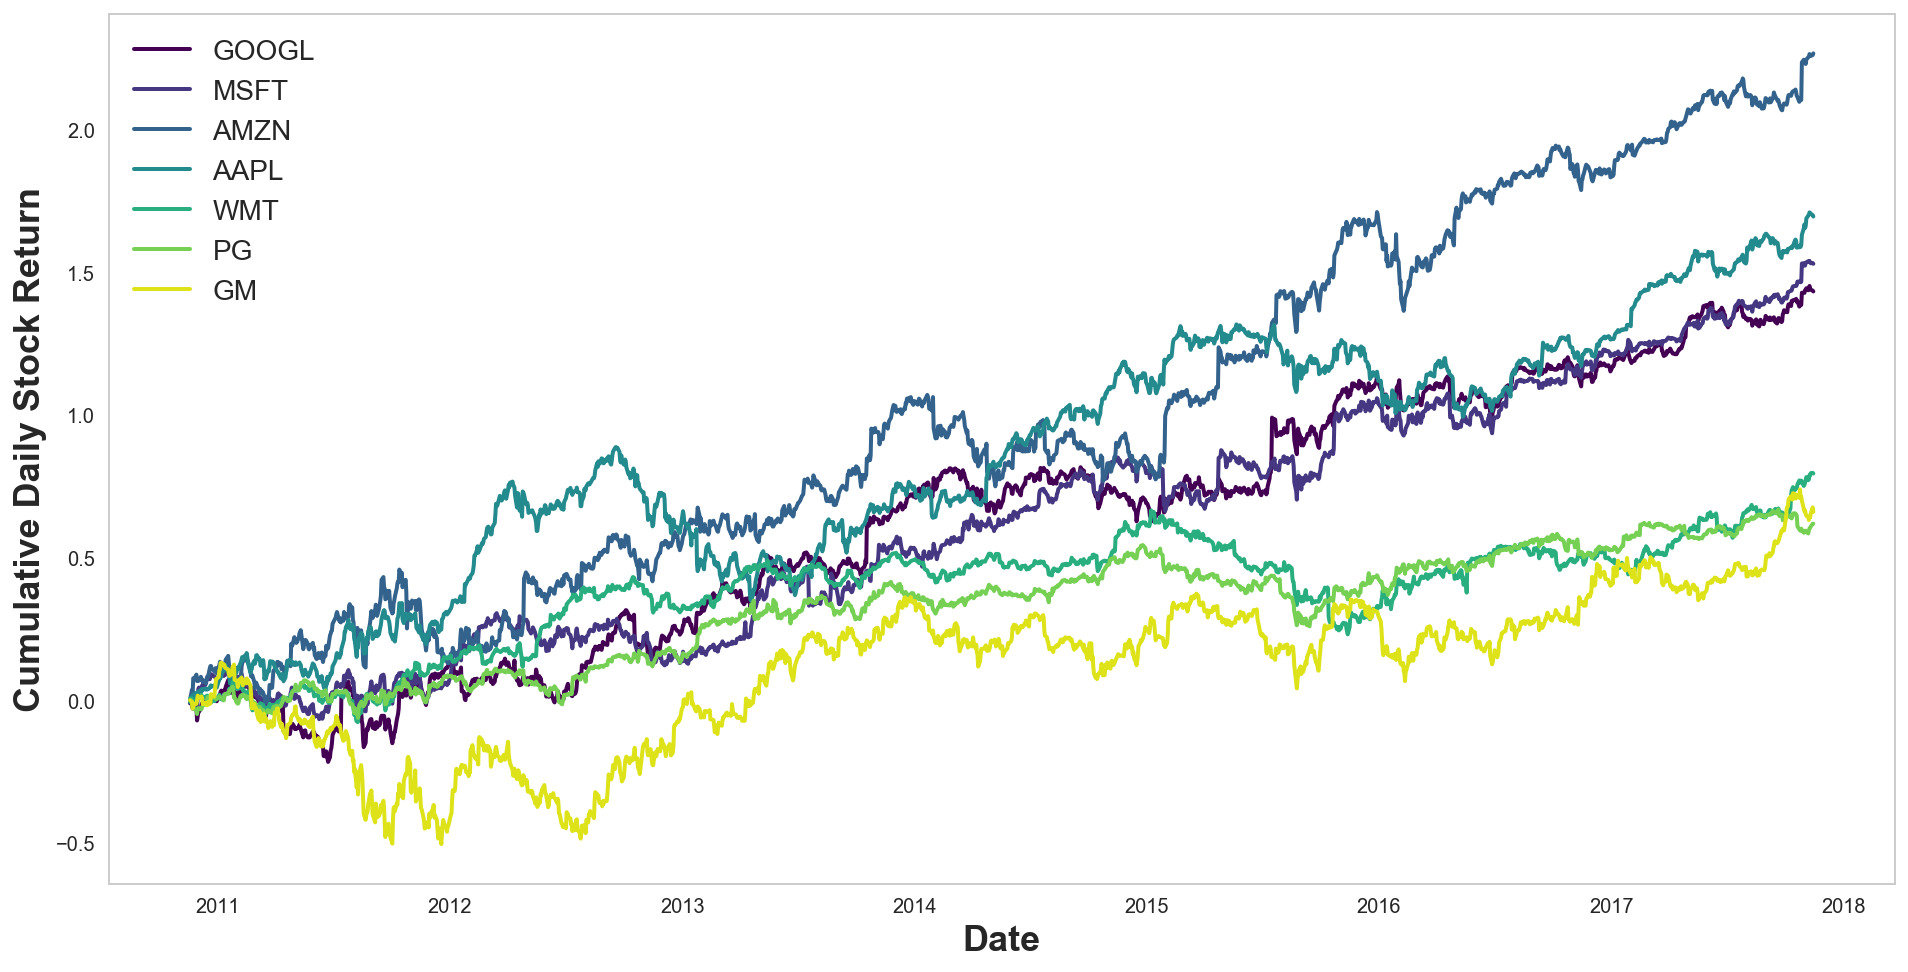

In [137]:
# get colormap viridis
colors = plt.cm.viridis(np.linspace(0,3,20))

# plot cumulative sum
for i in range(returns.shape[1]):
    plt.plot(returns.iloc[:, i].cumsum(), color=colors[i]);
plt.legend(loc='best');
plt.xlabel('Date');
plt.ylabel('Cumulative Daily Stock Return');
plt.show()

Comparing the plots above we would conclude that the artificial data and the real market data might look quite similar. Do not be fooled, the underlying statistical characterstics vary greatly with regard to distributional specifics.



# Part 2: Modern Portfolio Theory with Python

<a href="https://en.wikipedia.org/wiki/Modern_portfolio_theory">**Modern portfolio theory (MPT)**</a>, or **mean-variance analysis**, introduced by **Harry Markowitz**, is a mathematical framework for assembling a portfolio of assets such that the expected return is maximized for a given level of risk, defined as variance. Its key insight is that an asset's risk and return should not be assessed by itself, but by how it contributes to a portfolio's overall risk and return.

The MPT assumes that investors are rational and risk averse. That is, given two portfolios that offer the same expected return, investors will prefer the less risky one. Thus, an investor will take on increased risk only if compensated by higher expected returns. Conversely, an investor who wants higher expected returns must accept more risk. In a perfect market the trade-off will be exactely the same for all investors, but different investors will evaluate the trade-off differently in accordance to their risk appetite. 

## Expected Portfolio Risk and Return

Consider an asset portfolio consisting of $i=1, \dots, N$ assets. Let $R_i$ denote the return on asset $i$ and expect that the following holds:

\begin{align}
R_i \ &\sim{iid} \ \mathcal{N}(\mu_i, \sigma_i^2) \\
\text{cov}(R_i, R_j) & = \sigma_{ij}
\end{align}

The expected return of the portfolio $R$ is calculated by the summing the weighted expected returns for each asset $R_i$ in the portfolio:

$$
E[R_i] = \sum_{i=1}^N \omega_i \cdot R_i
$$

where $\omega_i$ are the corresponding weights of asset $i$ in the portfolio. MPT tells us that simply looking at the expected return of a portfolio is not enough. If we are interested in the comparative performance of a portfolio we additionally need to consider the volatility of the stocks within it. The portfolio variance is calcualted as

$$
\sigma_p^2 = \sum_i \omega_i^2 \sigma_i^2 + \sum_i \sum_{j \neq i} \omega_i \omega_j \sigma_i \sigma_j \rho_{ij}
$$
where $\sigma_i \sigma_j \rho_{ij} = \sigma_{ij}$ is the correlation coefficient.


## Portfolio Characteristics with Matrix Algebra

Using matrix notation we can express our calculations more elegantely. Let the following $N \times 1$ vectors contain the asset returns and portfolio weights

$$
\textbf{R} = 
\begin{bmatrix}
R_1 \\
R_2 \\
\vdots \\
R_N \\
\end{bmatrix}, \quad
\mathbf{\omega} = 
\begin{bmatrix}
\omega_1 \\
\omega_2 \\
\vdots \\
\omega_N \\
\end{bmatrix},
$$

Under the $iid$ normality assumption all returns are jointly normally distributed and this joint distribution is completely characterized by the means, variances and covariances of the returns. The mean vector and the variance-covariance matrix of the portfolio are denoted

$$
E[\textbf{R}] = E 
\begin{bmatrix}
R_1 \\
R_2 \\
\vdots \\
R_N \\
\end{bmatrix} =
\begin{bmatrix}
E[R_1] \\
E[R_2] \\
\vdots \\
E[R_N] \\
\end{bmatrix}  =
\begin{bmatrix}
\mu_1 \\
\mu_2 \\
\vdots \\
\mu_N \\
\end{bmatrix} = \mathbf{\mu}, \quad
\Sigma = 
\begin{bmatrix}
\sigma_{11} & \sigma_{12} & \cdots & \sigma_{1N} \\
\sigma_{21} & \sigma_{22} & \cdots & \sigma_{2N} \\
\vdots & \vdots & \ddots & \vdots\\
\sigma_{N1} & \sigma_{N2} & \cdots & \sigma_{NN} \\
\end{bmatrix}.
$$

With this notation at hand, the expected portfolio return $R$ and expected portfolio variance $\sigma^2$ are calculated by:

\begin{align}
R & = \omega^T \mu \\
\sigma^2 & = \omega^T \Sigma \omega
\end{align}


## Building Available Market Portfolios

With the following functions we can create random portfolio weights which are used to construct random portfolios from the included returns series. For these randomly created portfolios we calculate the means and standard deviation, and finally plot the set of obtain random portfolios.

In [116]:
def create_portfolio_weights(n_assets):
    '''
    returns randomly choosen portfolio weights that sum to one
    '''
    w = np.random.rand(n_assets)
    return w / w.sum()

In [138]:
def evaluate_portfolio(returns):
    ''' 
    returns the mean and standard deviation of returns for a random portfolio
    '''
    # in case a resampler is used
    returns = pd.DataFrame(returns)   
    
    # calculate from covariance, asset returns and weights
    cov = np.matrix(returns.cov())
    R = np.matrix(returns.mean())
    w = np.matrix(create_portfolio_weights(returns.shape[1]))
    
    # calculate expected portfolio return and risk
    mu = w * R.T
    sigma = np.sqrt(w * cov * w.T)
    
    return mu, sigma

Function <code>evaluate_portfolio</code> implements the matrix calculation for the mean and standard deviations as shown in theformulas above.

In [139]:
def create_random_portfolios(returns, n_portfolios=1500):
    '''
    plots randomly created portfolios
    '''
    # calculate mean and std for every portfolio
    pf_mus, pf_sigmas = np.column_stack([evaluate_portfolio(returns) for _ in range(n_portfolios)])

    return pf_mus, pf_sigmas

Using these function, we create a set of 3000 portfolios that are optainable by randomly weighting the available assets.

In [212]:
pf_mus, pf_sigmas = create_random_portfolios(artificial_returns, n_portfolios=3000)

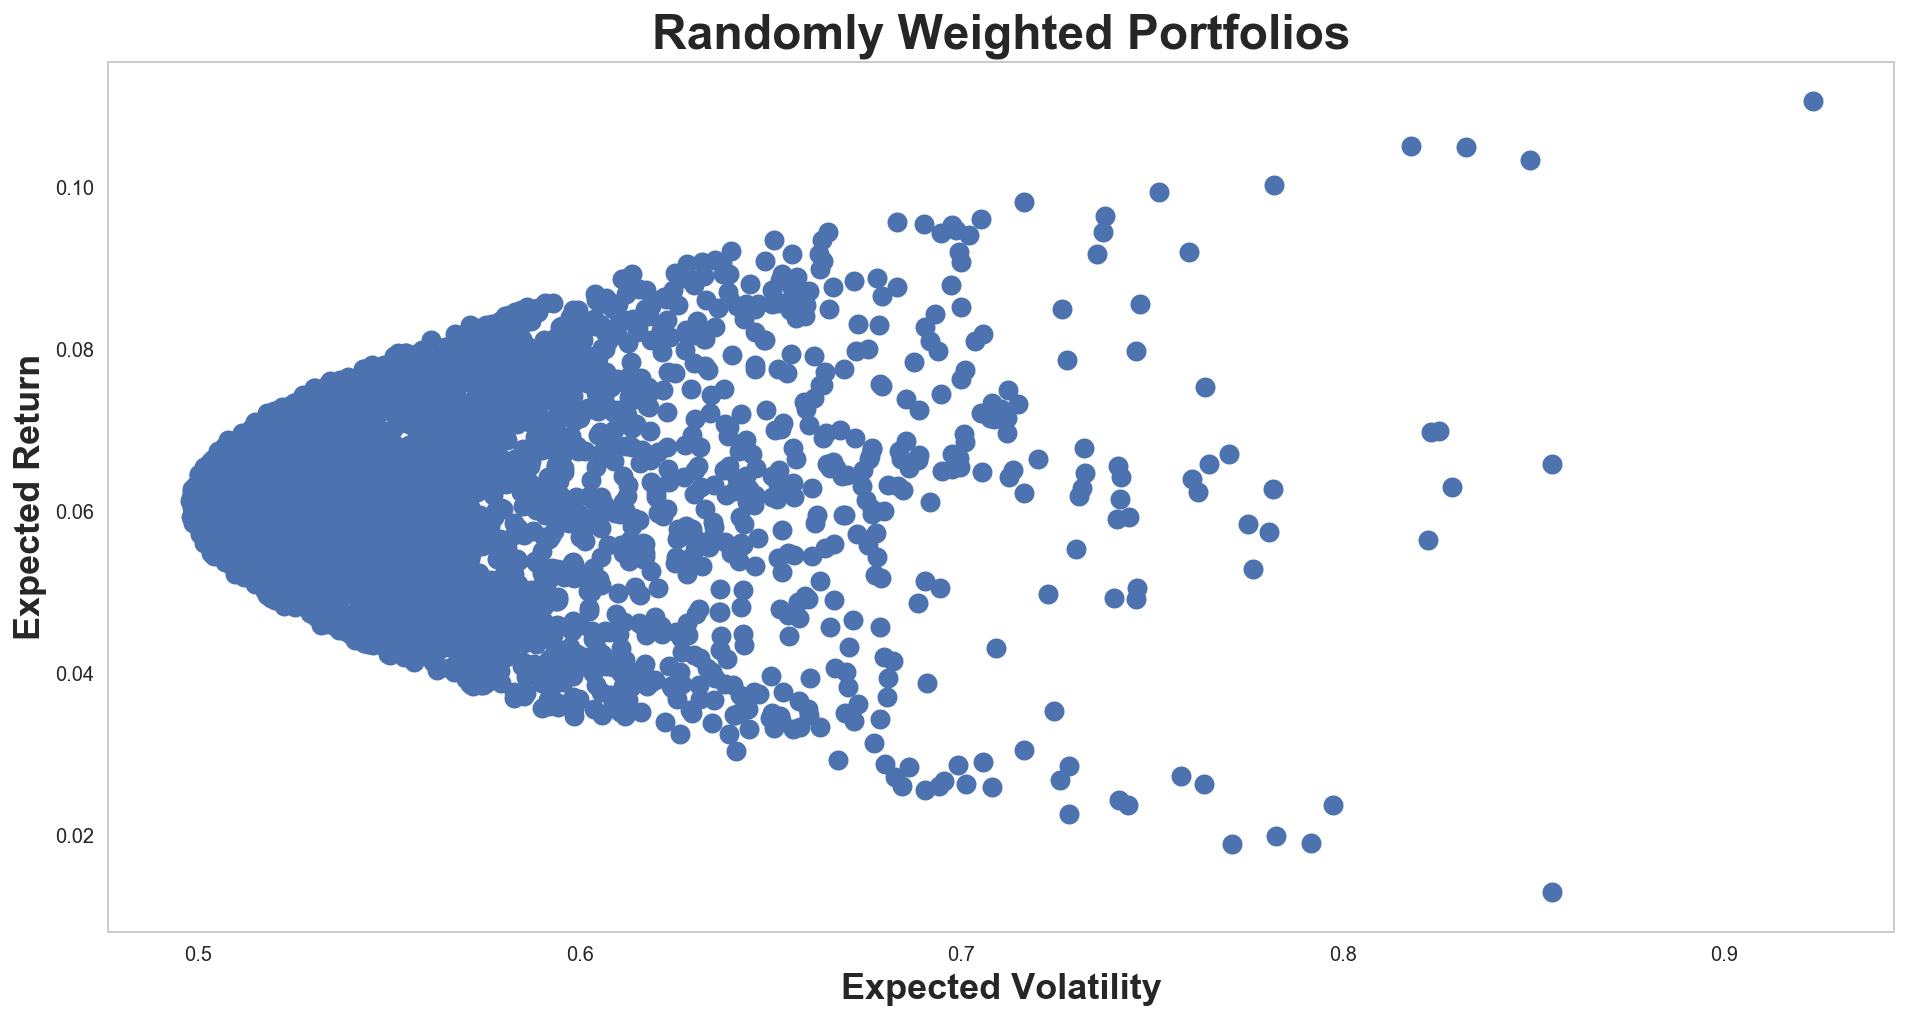

In [213]:
# scatter plot for expected return and volatility
plt.plot(pf_sigmas, pf_mus, 'o', markersize=10)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Randomly Weighted Portfolios')
plt.show()

It is easy to see that some of the randomly assembled portfolios perform better than others. The leftmost point in this plot is the least risky investment portfolio which earns exactely the average over the whole range of expected portfolio returns. The higher a point is on the Y axis the higher the expected portfolio return. 


# Part 3: Efficient Market Frontier 

Remember that a rational investor will always choose the volatility minimizing portfolio for a given level of return or the return maximizing portfolio for a given level of volatility. This notion i referred to as portfolio optimization. Thus, it would make no sense to hold any other portfolio than those on the outermost surface line on the upper half of the graph. This line is called the **Efficient Market Frontier**.

Our moptimization problem boils down to the case of minimizing the variance with respect to the weight parameters for a given vector of returns and the assumption that all portfolio weights sum to one:

\begin{align}
\min{\omega} \quad \omega^T \Sigma \omega \quad \text{s.t.} \quad \mu = \omega^T \mu^* \quad \text{and} \quad \omega^T \mathbf{1} = 1
\end{align}

which can be solved using quadratic programming.


## Quadratic Programming

Quadratic programming (QP) is the process of solving a (linearly constrained) quadratic optimization problem. That is,  optimizing (minimizing or maximizing) a quadratic function of several variables subject to linear constraints on these variables.

Quadratic programming is handily implemented within the module <code>cvxopt</code> which will be used in the latter. The official documentation as well as <a href="https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf">these notes</a> will help you get started with the package. For those who have trouble (like me) installing the <code>cvxopt</code> module will find this <a href="https://stackoverflow.com/questions/17905460/problems-on-installing-cvxopt">Stackoverflow link</a> helpful. Essentially, you will need to install the <code>numpy</code> distribution provided by <a href="https://www.lfd.uci.edu/~gohlke/pythonlibs/">this</a> site.

In [224]:
import cvxopt as opt
from cvxopt import solvers

def calculate_efficient_frontier(returns):
    '''
    returns optimal portfolio weights and corresponding sigmas for a desired optimal portfolio return
    Params:
    - returns: T x N matrix of observed data
    '''
    returns = pd.DataFrame(returns)
    cov = np.matrix(np.cov(returns.T))
    N = returns.shape[1]
    pbar = np.matrix(returns.mean())
    
    # define list of optimal / desired mus for which we'd like to find the sigmas
    optimal_mus = []
    r_min = pbar.mean()    # minimum expected return
    for i in range(50):
        optimal_mus.append(r_min)
        r_min += (pbar.mean() / 100)
    
    # constraint matrices for quadratic programming
    P = opt.matrix(cov)
    q = opt.matrix(np.zeros((N, 1)))
    G = opt.matrix(np.concatenate((-np.array(pbar), -np.identity(N)), 0))
    A = opt.matrix(1.0, (1,N))
    b = opt.matrix(1.0)
    
    # calculate portfolio weights, every weight vector is of size Nx1
    opt.solvers.options['show_progress'] = False
    # find optimal weights with qp(P, q, G, h, A, b)
    optimal_weights = [solvers.qp(P, q, G, opt.matrix(np.concatenate((-np.ones((1, 1)) * mu, np.zeros((N, 1))), 0)), A, b)['x'] for mu in optimal_mus]
    # \sigma = w^T * Cov * w
    optimal_sigmas = [np.sqrt(np.matrix(w).T * cov.T.dot(np.matrix(w)))[0,0] for w in optimal_weights]
    
    return optimal_weights, optimal_mus, optimal_sigmas

For a given list of optimal portfolio returns <code>optimal_mus</code> the corresponding optimal portfolio weights are calculated which are used to derive the optimal corresponding volatility. <code>opt_sigmas</code> is calculated as before like $\sigma  = \sqrt{\omega^T \Sigma \omega}$.

## Simulated Data

With the simulated data generated earlier we can find the optimal portfolios for given time series.

In [225]:
# calculate mus and sigmas for all and the optimal portfolios
pf_mus, pf_sigmas = create_random_portfolios(artificial_returns, n_portfolios=3000)
optimal_weights, optimal_mus, optimal_sigmas = calculate_efficient_frontier(artificial_returns)

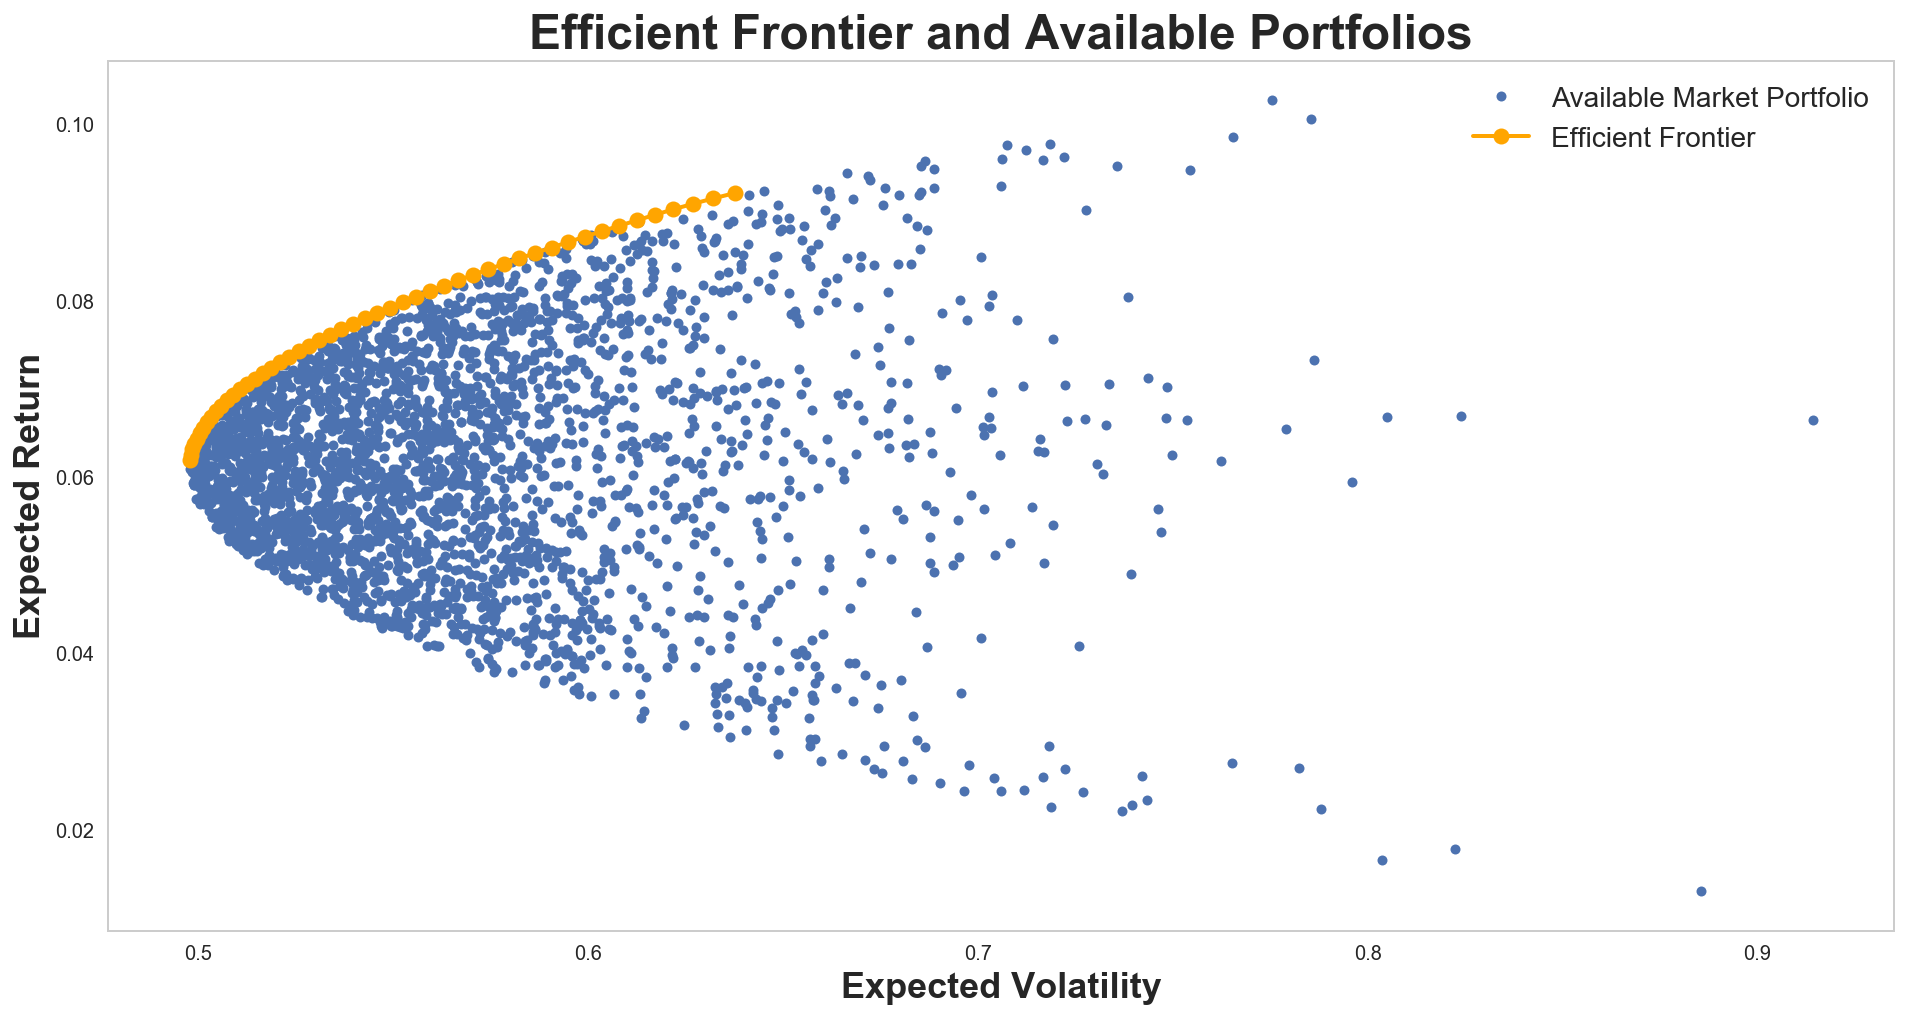

In [226]:
plt.plot(pf_sigmas, pf_mus, 'o', markersize=5, label='Available Market Portfolio')
plt.plot(optimal_sigmas, optimal_mus, 'y-o', color='orange', markersize=8, label='Efficient Frontier')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier and Available Portfolios')
plt.legend(loc='best')
plt.show()

The orange line indicates the set of efficient market portfolios, that is, those portfolios that have minimal risk for a given level of expected return.

## Implementation on Economic Data


In [227]:
pf_mus, pf_sigmas = create_random_portfolios(returns, n_portfolios=30000)

In [228]:
optimal_weights, optimal_mus, optimal_sigmas = calculate_efficient_frontier(returns)

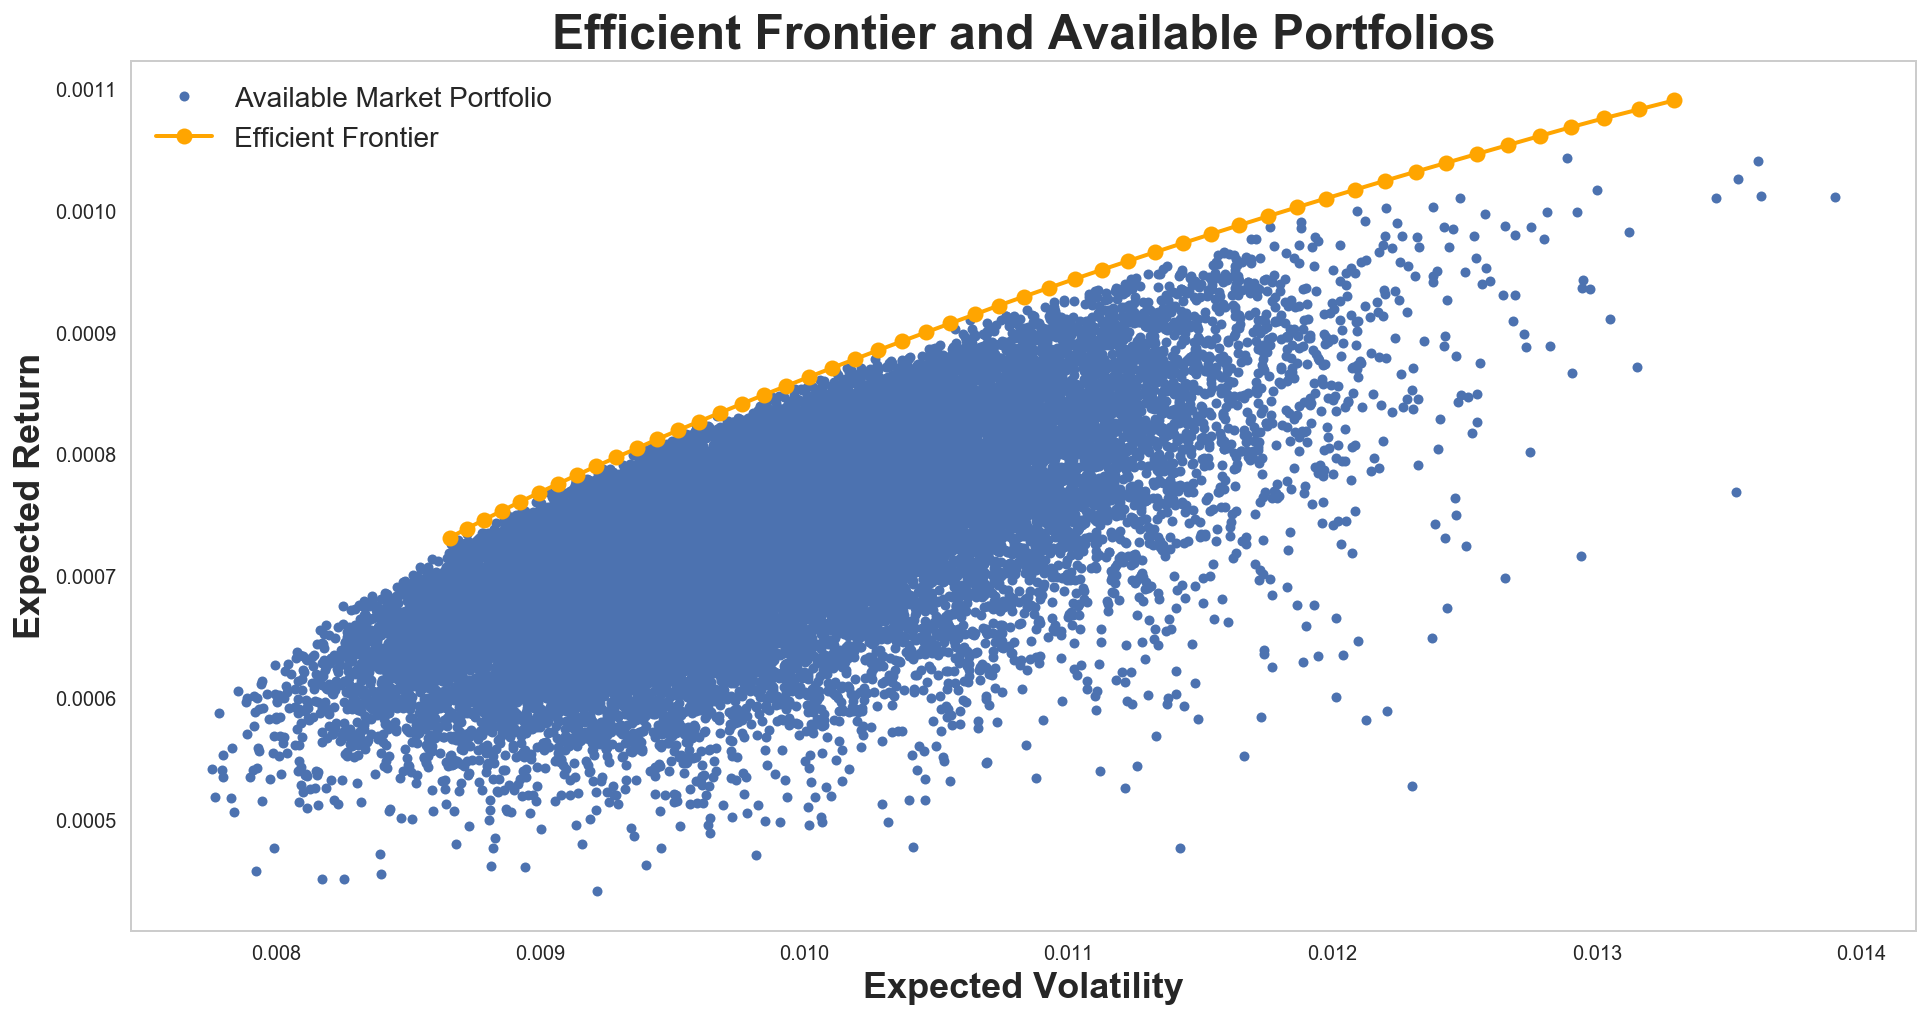

In [229]:
plt.plot(pf_sigmas, pf_mus, 'o', markersize=5, label='Available Market Portfolio')
plt.plot(optimal_sigmas, optimal_mus, 'y-o', color='orange', markersize=8, label='Efficient Frontier')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier and Available Portfolios')
plt.legend(loc='best')
plt.show()

As it can be seen in the plot above, the distribution of available portfolios greatly differs from what we would expect in the artificial data case. This is owed to the fact that real market data is oftentimes not normally distributed as it is assumed by MPT. This leads to a not perfectly shapes curve as it was the case for the artificial data.

# Summary

Using Python we were able to plot various portfolios that can be constructed from available stocks in the market. Every financial asset has its own risk and return profile. If financial assets are put into a portfolio we observe diversification effects which led us to the optimization of the corresponding portfolio asset weights to obtain a minimal risk portfolio for a desired level of return.

For further discussion on the topic, <a href="https://www.investopedia.com/articles/06/mpt.asp">this Investopedia article of Ben McClure</a> is a very good starter and overview of the modern portfolio theory topic.


# Discussion

Modern portfolio theory has had a marked impact on how investors perceive risk, return and portfolio management. The theory demonstrates that portfolio diversification can reduce investment risk. In fact, modern money managers routinely follow its precepts.

That being said, MPT has some shortcomings in the real world. For starters, it often requires investors to rethink notions of risk. Sometimes it demands that the investor take on a perceived risky investment (futures, for example) in order to reduce overall risk. That can be a tough sell to an investor not familiar with the benefits of sophisticated portfolio management techniques.

Furthermore, MPT assumes that it is possible to select stocks whose individual performance is independent of other investments in the portfolio. But market historians have shown that there are no such instruments. In times of market stress, seemingly independent investments do act as though they are related.

Likewise, it is logical to borrow to hold a risk-free asset and increase your portfolio returns, but finding a truly risk-free asset is another matter. Government-backed bonds are presumed to be risk free, but, in reality, they are not. Securities such as gilts and U.S. Treasury bonds are free of default risk, but expectations of higher inflation and interest rate changes can both affect their value.

Then there is the question of the number of stocks required for diversification. How many is enough? Mutual funds can contain dozens and dozens of stocks. Investment guru William J. Bernstein says that even 100 stocks is not enough to diversify away unsystematic risk. By contrast, Edwin J. Elton and Martin J. Gruber in their book "Modern Portfolio Theory And Investment Analysis" (1981), conclude that you would come very close to achieving optimal diversity after adding the twentieth stock.

The gist of MPT is that the market is hard to beat and that the people who beat the market are those who take above-average risk. It is also implied that these risk takers will get their comeuppance when markets turn down.

Then again, investors such as Warren Buffett remind us that portfolio theory is just that – theory. At the end of the day, a portfolio's success rests on the investor's skills and the time he or she devotes to it. Sometimes it is better to pick a small number of out-of-favor investments and wait for the market to turn in your favor than to rely on market averages alone.

# Resources

* https://en.wikipedia.org/wiki/Modern_portfolio_theory
* https://en.wikipedia.org/wiki/Quadratic_programming
* https://www.codecogs.com/latex/eqneditor.php
* http://faculty.washington.edu/ezivot/econ424/portfolioTheoryMatrix.pdf
* http://cvxopt.org/userguide/coneprog.html#quadratic-programming
* https://plot.ly/ipython-notebooks/markowitz-portfolio-optimization/
* https://blog.quantopian.com/markowitz-portfolio-optimization-2/
* http://ahmedas91.github.io/blog/2016/03/01/efficient-frontier-with-python/
* https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
* https://www.investopedia.com/articles/06/mpt.asp
